In [20]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


In [21]:
# 2. Load and Inspect Data
df = pd.read_csv("data.csv")  # Replace with your actual filename

# Drop missing values
df.dropna(inplace=True)

print("Dataset shape:", df.shape)
print("Column Types:\n", df.dtypes)
print("Class Balance:\n", df['isFraud'].value_counts())


Dataset shape: (6362620, 11)
Column Types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
Class Balance:
 0    6354407
1       8213
Name: isFraud, dtype: int64


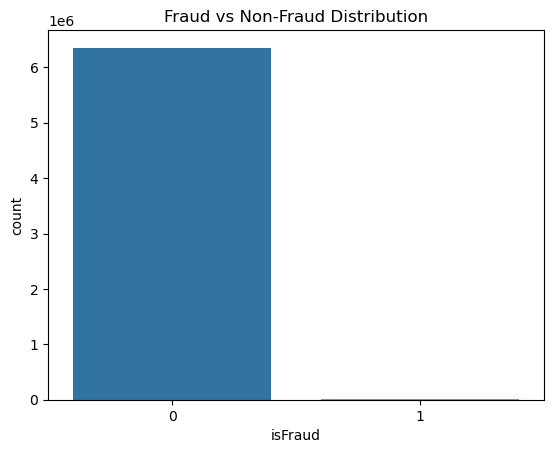

AttributeError: 'numpy.int64' object has no attribute 'startswith'

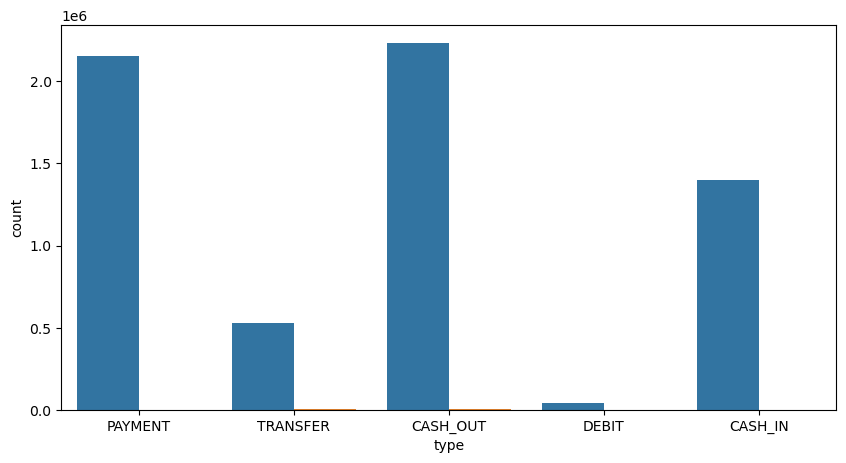

In [22]:
# 3. EDA - Basic Visualizations
sns.countplot(data=df, x='isFraud')
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# Transaction type fraud correlation
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='type', hue='isFraud')
plt.title("Transaction Type vs Fraud")
plt.show()

# Amount distribution
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='isFraud', y='amount')
plt.title("Amount Distribution by Fraud")
plt.yscale("log")
plt.show()


In [23]:
# 4. Drop Irrelevant Columns (e.g. names)
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)

# One-Hot Encoding for 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)


In [24]:
# 5. Split Features and Labels
X = df.drop('isFraud', axis=1)
y = df['isFraud']


In [25]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
# 8. Apply SMOTE to Handle Imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check balance
print("After SMOTE:\n", pd.Series(y_train_smote).value_counts())


After SMOTE:
 0    5083526
1    5083526
Name: isFraud, dtype: int64


In [27]:
print(X_train.dtypes)


step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud      int64
type_CASH_OUT       uint8
type_DEBIT          uint8
type_PAYMENT        uint8
type_TRANSFER       uint8
dtype: object


In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Build a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [29]:
# Utility function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


---- Random Forest ----
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.63      0.97      0.76      1643

    accuracy                           1.00   1272524
   macro avg       0.82      0.98      0.88   1272524
weighted avg       1.00      1.00      1.00   1272524



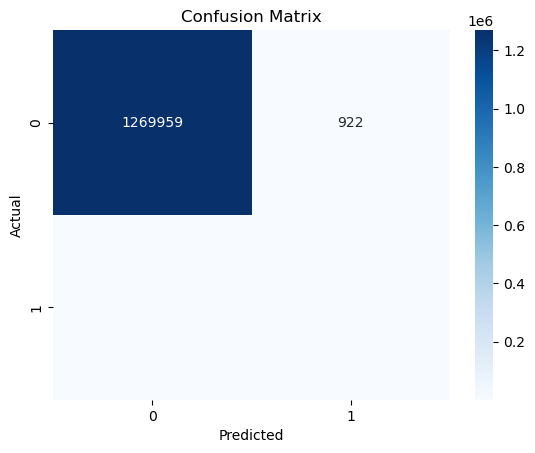

In [30]:
# 9.1 Random Forest
print("---- Random Forest ----")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
evaluate_model(rf, X_test_scaled, y_test)


---- XGBoost ----
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.34      1.00      0.50      1643

    accuracy                           1.00   1272524
   macro avg       0.67      1.00      0.75   1272524
weighted avg       1.00      1.00      1.00   1272524



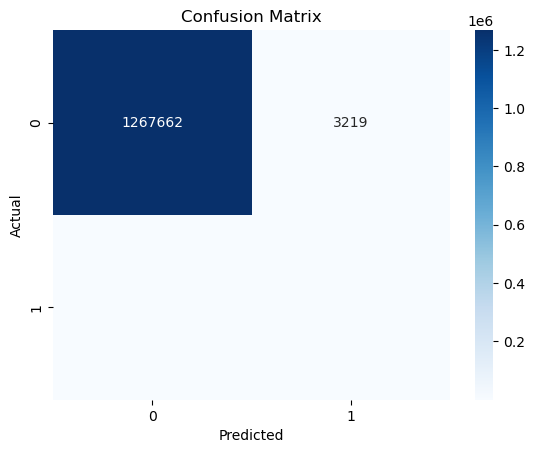

In [31]:
# 9.2 XGBoost
print("---- XGBoost ----")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_smote, y_train_smote)
evaluate_model(xgb, X_test_scaled, y_test)


In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

for name, model in models.items():
    print(f"\n================ {name} ================\n")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))



================ Logistic Regression ================

Confusion Matrix:
 [[1218400   52482]
 [  37011 1233870]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96   1270882
           1       0.96      0.97      0.97   1270881

    accuracy                           0.96   2541763
   macro avg       0.96      0.96      0.96   2541763
weighted avg       0.96      0.96      0.96   2541763

Accuracy Score: 0.9647909738240741

================ Decision Tree ================

Confusion Matrix:
 [[1270265     617]
 [    244 1270637]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763

Accuracy Score: 0.9996612587404884

===

In [34]:
y_pred = model.predict(X_test_scaled)


In [35]:
from sklearn.metrics import accuracy_score

accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name}: Accuracy = {acc:.4f}")


Logistic Regression: Accuracy = 0.9648
Decision Tree: Accuracy = 0.9997
Gaussian Naive Bayes: Accuracy = 0.6825
